In [2]:
LIVENOTEBOOK = False
import cv2
cv2.__version__



'3.3.0'

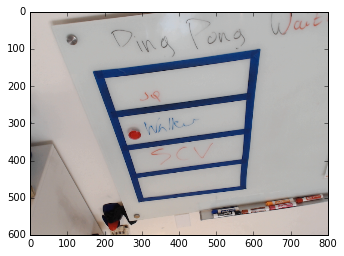

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim 
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
if LIVENOTEBOOK:
    %matplotlib inline
    img = cv2.imread("../reference/frame17978.png")
    # test plotting
    imshow(img)

In [6]:
def tightbluemask(image, clean=True):
    """Returns a mask (grayscale image) which is >0 in the area of the blue grid."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    threshold  = np.array([[103,95,30],[120,240,125]])
    mask = cv2.inRange(hsv, threshold[0,:], threshold[1,:])

    if clean:
        # close gaps
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)) 
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        # remove speckles
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask



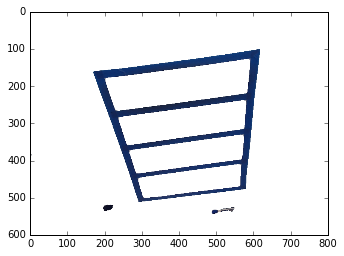

In [7]:
# step 1, extract the right kind of blue
if LIVENOTEBOOK:
    image = img
    mask = tightbluemask(img)
    bluewhite = img.copy()
    bluewhite[mask==0,:] = (255,255,255)
    imshow(bluewhite)

Found 5 outer contours


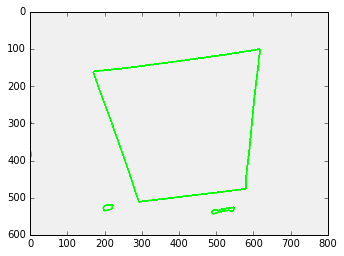

In [8]:
# step 2 :extract raw contours
if LIVENOTEBOOK:
    dst = np.zeros(image.shape, np.uint8)
    dst[:]=(240,240,240)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    print("Found %d outer contours" % len(cnts))
    cv2.drawContours(dst, cnts, -1, (0,255,0), 3)
    plt.imshow(dst)

Found shape with sides: 15
Found shape with sides: 17
Found shape with sides: 10
Found shape with sides: 6
Found shape with sides: 4
-- Found: 445 x 409


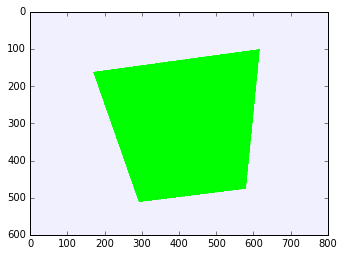

In [9]:
# simplify contours, find one that is a rectangle
def find_outer_rect(cnts, img=None):
    """Find the one large rectangle in a list of contours, returns an approximated contour 
    and optionally an image of the contour
    
    If an optional image is passed, this routine will return a filled 3-channel image of the found contour.
    In channel 0, the area inside the outer rect is 0, 255 elsewhere."""
    
    if not img is None:
        dst = np.zeros(img.shape, np.uint8)
        dst[:] = (255,240,240)
    else:
        dst = None
    for c in cnts:
        peri = 0.01 * cv2.arcLength(c, True)  # approximate such that points are never > 0.01*perimeter away
        approx = cv2.approxPolyDP(c, peri, True)
        print ("Found shape with sides: %d" % len(approx))
        if len(approx) == 4:
                approx = np.reshape(approx,[4,2]) # drop 2nd dimension 
                xsize = approx[:,0].max() - approx[:,0].min()
                ysize = approx[:,1].max() - approx[:,1].min()
                if xsize > 300 and ysize > 150:
                    print ("-- Found: %d x %d" % (xsize, ysize))
                    if not img is None:
                        cv2.drawContours(dst, [approx], -1, (0,255,0), cv2.FILLED)
                    break
                else:
                    print ("-- Rejected rectangle: %d x %d" % (xsize, ysize))
    else:
        raise ValueError("No outer rectangle found")
    return approx, dst

# step 3: get outer rectangle
if LIVENOTEBOOK:
    (outerRectangle, filledMask) = find_outer_rect(cnts, img)
    imshow(filledMask)

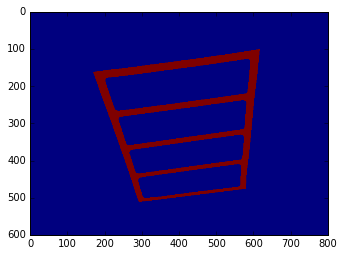

In [10]:
# step 4: remove area outside of outer rectangle from mask (ie set to 0)
if LIVENOTEBOOK:
    mask[filledMask[:,:,0]>0]=0
    plt.imshow(mask)


In [11]:
def find_inner_rectangles(img):
    # find inner rectangles
    _, cnts, hier = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = []
    for i in range(len(cnts)):
        contour = cnts[i]
        _,_,w,h = cv2.boundingRect(contour)
        if w>100 and h>50:
            contours.append(contour)
        else:
            hier[0, i, :] = -2 # mark for deletion

    hier = np.delete(hier, np.where(hier[0,:,-1] == -2)[0], 1)

    assert len(contours) == 5, "there should be five contours: found %d" % len(contours)
    assert hier[0,0,-1] == -1, "first contour should be the outer one, ie it has no parent"
    assert np.all(hier[0,1:5,-1] == 0), "all other contours should have the first contour as their parent"
    hier = np.delete(hier, 0, 1) # remove parent from list of hier
    contours = contours[1:] # remove parent from contours
    contours.sort(key=lambda a: a[:,0,1].min()) # sort contours by minimum y value (top down)
    return contours, hier

# step 5: find inner rectangles
if LIVENOTEBOOK:
    contours, hier = find_inner_rectangles(mask)
    assert len(contours) == 4, "Expected four inner rectangles, found %d " % len(contours)


In [12]:
hier

array([[[ 2, -1, -1,  0],
        [ 3,  1, -1,  0],
        [ 4,  2, -1,  0],
        [-1,  3, -1,  0]]], dtype=int32)

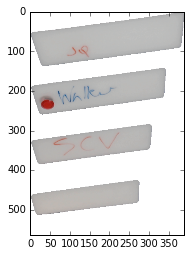

In [13]:
def get_inner_rect_contents(contours, image):
    """for each inner rectangle in 'contours', extract a standard size rectange with 
    the (masked) contents of this rectangle from 'image'.  Returns a list of cropped images. """

    # determine size of largest (topmost) bounding box
    _,_,bbw,bbh = cv2.boundingRect(contours[0])
    boxes = []
    kernel =  np.ones((5,5), np.uint8)
    for contour in contours:
        # compute mask from contour by filling
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        # make mask about 5px smaller on all sides
        mask = cv2.erode(mask, kernel)
        # create white box and copy image in where mask is true
        box = np.zeros_like(image)
        box.fill(255)
        box[mask == 255] = image[mask == 255] 
        # crop to bounding box
        bbx, bby, w, h = cv2.boundingRect(contour)
        assert bbw >= w and bbh >= h, "all boxes should be smaller than the top one"
        box = box[bby:(bby+bbh), bbx:(bbx+bbw), :]
        boxes.append(box)
    return boxes
    
# step 6: get contents of inner rectangles (boxes)
if LIVENOTEBOOK:
    boxes = get_inner_rect_contents(contours, img)
    imshow(np.concatenate(boxes))

In [27]:
def get_contents(imagepath):
    img = cv2.imread(imagepath)

    # step 1, extract the right kind of blue
    # image = img
    mask = tightbluemask(img)
    bluewhite = img.copy()
    bluewhite[mask==0,:] = (255,255,255)
    
    # step 2 :extract raw contours
    dst = np.zeros(img.shape, np.uint8)
    dst[:]=(240,240,240)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    print("Found %d outer contours" % len(cnts))
    cv2.drawContours(dst, cnts, -1, (0,255,0), 3)
    
    # step 3: get outer rectangle
    (outerRectangle, filledMask) = find_outer_rect(cnts, img)
    
    # step 4: remove area outside of outer rectangle from mask (ie set to 0)
    mask[filledMask[:,:,0]>0]=0
    
    # step 5: find inner rectangles
    contours, hier = find_inner_rectangles(mask)
    assert len(contours) == 4, "Expected four inner rectangles, found %d " % len(contours)

    # step 6: get contents of inner rectangles (boxes)
    boxes = get_inner_rect_contents(contours, img)
    return boxes
    


Given code that can extract the contents of the inner rectangles (boxes), we can determine whether the 
contents have changed.


In [39]:
def threshold_boxes(boxes):
    """Given a list of images, adaptive threshold each image"""
    output = []
    for img in boxes:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dst = cv2.adaptiveThreshold(img, 160, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
        output.append(dst)
    return output


Found 5 outer contours
Found shape with sides: 13
Found shape with sides: 13
Found shape with sides: 10
Found shape with sides: 4
-- Rejected rectangle: 2 x 9
Found shape with sides: 4
-- Found: 445 x 409


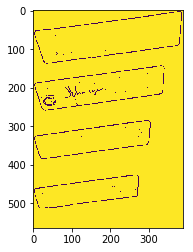

In [63]:
%matplotlib inline
box1full = get_contents("../reference/frame18073.png") 
box1full_th = threshold_boxes(box1full)
plt.imshow(np.concatenate(box1full_th))

Found 5 outer contours
Found shape with sides: 13
Found shape with sides: 13
Found shape with sides: 10
Found shape with sides: 4
-- Rejected rectangle: 2 x 9
Found shape with sides: 4
-- Found: 445 x 409


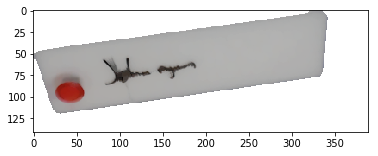

In [70]:
#try something else: first morph then substrction
jr = get_contents("../reference/frame18073.png")[1] 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
jr = cv2.morphologyEx(jr, cv2.MORPH_OPEN, kernel)
imshow(jr)

Found 5 outer contours
Found shape with sides: 12
Found shape with sides: 17
Found shape with sides: 11
Found shape with sides: 6
Found shape with sides: 4
-- Found: 445 x 409


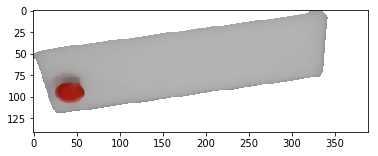

In [71]:
empty = get_contents("../reference/frame18074.png")[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
empty = cv2.morphologyEx(empty, cv2.MORPH_OPEN, kernel)
imshow(empty)

In [73]:
compare_ssim(jr, empty, multichannel=True)


0.95049821074410745

0.436141
(141, 389, 3)


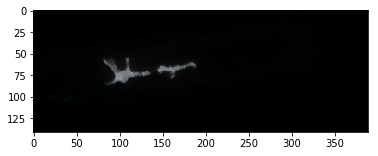

In [122]:
diff = cv2.absdiff(jr, empty)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)
print (diff.sum()/1e6)
print(diff.shape)
imshow(diff)

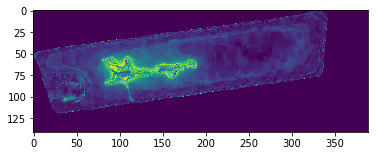

In [92]:

contentmask = np.sqrt(np.sum(diff**2, axis=2))
plt.imshow(contentmask)

Found 6 outer contours
Found shape with sides: 7
Found shape with sides: 16
Found shape with sides: 17
Found shape with sides: 8
Found shape with sides: 7
Found shape with sides: 4
-- Found: 445 x 410


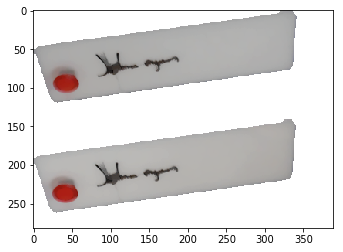

In [107]:
same = get_contents("../reference/frame18059.png")[1] # same only in box1
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
same = cv2.morphologyEx(same, cv2.MORPH_OPEN, kernel)
same = same[:,1:390,:] # crop to size of JR TODO

imshow(np.concatenate([jr, same], axis=0))


0.565449


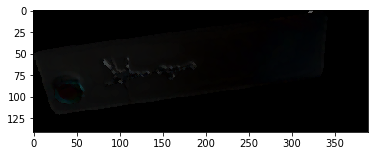

In [121]:

diff2 = cv2.absdiff(jr, same)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
diff2 = cv2.morphologyEx(diff2, cv2.MORPH_OPEN, kernel)
#contentmask2 = np.sqrt(np.sum(diff2**2, axis=2))
#plt.imshow(contentmask2)
print (diff2.sum()/1e6)
imshow(diff2)
#print (same.shape, jr.shape)